In [1]:
!pip install wget torchinfo
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=8418a33294d788f45a2e8edc6f14b04a7fed619d937785b0d75c778661ab14a0
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
--2025-04-06 10:38:32--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-04-06 10:38:32--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>] 

In [2]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [3]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [4]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [5]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

        self.attention_biases = None
        self.attention_bias_idxs = None

    def compute_attention_bias(self, resolution):

        points = list(itertools.product(range(resolution), range(resolution)))
        N = len(points)

        attention_offsets = {}
        idxs = []

        # if N = 196, then resolution = 14
        for p1 in points:
            for p2 in points:
                offset = (abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))
                if offset not in attention_offsets:
                    attention_offsets[offset] = len(attention_offsets)
                idxs.append(attention_offsets[offset])

        num_offsets = len(attention_offsets)

        # 각 attention head에 대해 num_offsets 만큼의 학습 가능한 Bias를 생성
        self.attention_biases = nn.Parameter(torch.zeros(self.num_heads, num_offsets).to(next(self.parameters()).device))
        self.attention_bias_idxs = torch.LongTensor(idxs).view(N, N).to(next(self.parameters()).device)

    def forward(self, x):
        B, N, C = x.shape
        resolution = int(N ** 0.5)

        if self.attention_biases is None or self.attention_bias_idxs.shape[0] != N:
            self.compute_attention_bias(resolution)

        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # qkv: (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2] # q, k, v: (B, num_heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * self.scale # attn: (B, num_heads, N, N)
        attn_bias = self.attention_biases[:, self.attention_bias_idxs].unsqueeze(0) # attn_bias: (1, num_heads, N, N)
        attn = attn + attn_bias
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [7]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [8]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x


In [9]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [10]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [11]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [12]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [13]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super().__init__()
        self.stem = Stem16()
        self.stage1 = LevitStage(256, 256, 4, 2, downsample=False)
        self.stage2 = LevitStage(256, 384, 6, 2, downsample=True)
        self.conv1x1 = nn.Sequential(nn.Conv2d(384, 512, 1), nn.BatchNorm2d(512), nn.ReLU(True))
        self.head = NormLinear(512, num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(512, num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)
        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)
        H = W = int(x.shape[1] ** 0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)
        x = self.conv1x1(x)
        x = torch.mean(x, dim=(2, 3))
        return self.head(x)

    def extract_features(self, x):
        x = self.stem(x)
        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)
        H = W = int(x.shape[1] ** 0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)
        x = self.conv1x1(x)
        return torch.mean(x, dim=(2, 3))

In [14]:
model = LevitDistilled(num_classes=9)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 5e-4
num_epochs = 30

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [15]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   5,641
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                               

In [16]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   5,641
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias           

In [17]:
class BSDALayer(nn.Module):
    def __init__(self, feature_dim, bsda_lambda=0.8) -> None:
        super().__init__()

        self.feature_dim = feature_dim
        self.bsda_lambda = bsda_lambda

        self.logvar = nn.Sequential(
            nn.Linear(self.feature_dim, self.feature_dim),
        )

        self.d = nn.Dropout(p=self.bsda_lambda)
        self.encoder = nn.Sequential(
            nn.Linear(self.feature_dim, self.feature_dim),
            nn.BatchNorm1d(self.feature_dim),
            nn.GELU(),

            nn.Linear(self.feature_dim, self.feature_dim),
            nn.BatchNorm1d(self.feature_dim),
            nn.GELU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.feature_dim, self.feature_dim),
            nn.BatchNorm1d(self.feature_dim),
            nn.GELU(),

            nn.Linear(self.feature_dim, self.feature_dim),
            nn.BatchNorm1d(self.feature_dim),
            nn.GELU(),
        )

    def modified_indicator_function(self, x):
        return torch.where(x >= 0, torch.sign(x), -torch.sign(x))

    def calc_a_tilde(self, a, m, multi=1):
        a = a.repeat(multi, 1)
        return a + self.d(m) * self.modified_indicator_function(a)

    def reparameterize(self, mu, logvar, multi=1):
        std = torch.exp(0.5 * logvar)
        std = std.repeat(multi, 1)
        eps = torch.randn_like(std, device=std.device)
        mu = mu.repeat(multi, 1)
        return eps * std + mu

    def forward(self, a, multi=1):
        """
            a: (batch_size, feature_dim)
            m: (batch_size, feature_dim)
            mu: (batch_size, feature_dim)
            logvar: (batch_size, feature_dim)
        """
        x = self.encoder(a)

        logvar = self.logvar(x)
        mu = torch.zeros_like(logvar, device=logvar.device)

        m = self.reparameterize(mu, logvar, multi)
        a_hat = self.decoder(m)

        return m, mu, logvar, a_hat

    def calc_kl_loss(self, mu, logvar):

        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return kl_loss

    def calc_recon_loss(self, a, a_hat, multi=1):
        recon_loss = torch.mean((a.repeat(multi, 1) - a_hat) ** 2) * 0.5
        return recon_loss


In [18]:
import torch.nn.init as init

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # CUDA 연산 시 동일한 결과 보장
    torch.cuda.manual_seed_all(seed)  # 멀티-GPU 환경에서 동일한 결과 보장
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 deterministic하게 설정
    torch.backends.cudnn.benchmark = False  # 연산 속도를 희생하고 일관된 연산을 수행

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):  # Conv 레이어 초기화
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):  # Linear 레이어 초기화
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):  # BatchNorm 초기화
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

set_seed(42)  # 랜덤 시드 고정
model.apply(initialize_weights)

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [19]:
train_dir = './train/NCT-CRC-HE-100K'

In [20]:
import cv2

def elastic_transform(image, alpha, sigma):
    """탄성 변형 적용"""

    if isinstance(image, torch.Tensor):
        image_np = image.permute(1, 2, 0).numpy()
    else:
        image_np = np.array(image)

    shape = image_np.shape[:2]

    ksize = 2 * int(sigma) + 1

    dx = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1), (ksize, ksize), sigma) * alpha
    dy = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1), (ksize, ksize), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))

    indices = np.stack((y + dy, x + dx), axis=-1).astype(np.float32)
    distorted_image = cv2.remap(image_np, indices, None, cv2.INTER_LINEAR)

    return distorted_image

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(p=0.75),
    #transforms.RandomVerticalFlip(p=0.75),
    transforms.Lambda(lambda x: elastic_transform(x, alpha=10, sigma=4)),
    transforms.ToTensor(),
])

In [22]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [23]:
import json

with open("default_index_dict.json", "r") as f:
    index_dict = json.load(f)
load_train_idx = index_dict["train_idx"]
load_val_idx = index_dict["val_idx"]
load_test_idx = index_dict["test_idx"]

In [24]:
dataset_train = datasets.ImageFolder(root=train_dir, transform=aug_transform)
dataset_eval = datasets.ImageFolder(root=train_dir, transform=transform)

train_data = Subset(dataset_train, load_train_idx)
val_data = Subset(dataset_eval, load_val_idx)
test_data = Subset(dataset_eval, load_test_idx)

In [25]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lr=learning_rate, params=model.parameters())

In [27]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [28]:
def train(model, train_loader, criterion, optimizer, device, epoch,
          use_bsda=False, bsda_layer=None, multi=10, bsda_alpha=0.5,
          kl_weight=8e-4, recon_weight=1.0, use_ori=True, num_epochs=30):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    ratio = min(bsda_alpha * (epoch / (num_epochs // 2)), bsda_alpha) if use_bsda else 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        features = model.extract_features(inputs)
        y_hat = model.head(features)

        if use_bsda:
            m, mu, logvar, a_hat = bsda_layer(features, multi=multi)
            a_tilde = bsda_layer.calc_a_tilde(features, m, multi=multi)
            y_hat_tilde = model.head(a_tilde)

            loss_task = criterion(y_hat, labels)
            loss_task_tilde = criterion(y_hat_tilde, labels.repeat(multi,))
            loss_kl = bsda_layer.calc_kl_loss(mu, logvar)
            loss_recon = bsda_layer.calc_recon_loss(features, a_hat, multi)
            loss_bsda = kl_weight * loss_kl + recon_weight * loss_recon
            loss = loss_task_tilde + loss_bsda
            if use_ori:
                loss = loss * ratio + loss_task
        else:
            loss = criterion(y_hat, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(y_hat, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Train Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")

In [29]:
# Global variable to track the best validation loss
best_val_loss = float('inf')

def evaluate(model, data_loader, criterion, device, epoch, phase="Validation", save_path="best_model.pth"):
    global best_val_loss  # Reference global best validation loss
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader, desc=f"{phase}")):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Check if this is the best model so far (lowest validation loss)
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss
        torch.save(model.state_dict(), save_path)
        print(f"New best model saved with {phase} loss {epoch_loss:.4f} at {save_path}")

    #return epoch_loss, accuracy, balanced_acc

In [30]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [31]:
bsda_layer = BSDALayer(feature_dim=512, bsda_lambda=0.8).to(device)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device, epoch,
          use_bsda=True,
          bsda_layer=bsda_layer,
          multi=10,
          bsda_alpha=0.5,
          kl_weight=8e-4,
          recon_weight=1.0,
          use_ori=True,
          num_epochs=num_epochs)

    evaluate(model, val_loader, criterion, device, epoch, phase="Validation")


Epoch 1/30


Epoch 1: 100%|██████████| 2188/2188 [05:25<00:00,  6.73it/s]


Train Loss: 0.5033, Accuracy: 82.22%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.85it/s]


Validation Loss: 0.6070, Validation Accuracy: 87.41%
Balanced Accuracy: 0.8676
New best model saved with Validation loss 0.6070 at best_model.pth

Epoch 2/30


Epoch 2: 100%|██████████| 2188/2188 [05:23<00:00,  6.76it/s]


Train Loss: 0.3026, Accuracy: 91.64%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]


Validation Loss: 0.9684, Validation Accuracy: 66.43%
Balanced Accuracy: 0.6359

Epoch 3/30


Epoch 3: 100%|██████████| 2188/2188 [05:20<00:00,  6.82it/s]


Train Loss: 0.2674, Accuracy: 94.08%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]


Validation Loss: 0.6110, Validation Accuracy: 75.93%
Balanced Accuracy: 0.7609

Epoch 4/30


Epoch 4: 100%|██████████| 2188/2188 [05:22<00:00,  6.79it/s]


Train Loss: 0.2596, Accuracy: 95.31%


Validation: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]


Validation Loss: 0.9137, Validation Accuracy: 63.43%
Balanced Accuracy: 0.6200

Epoch 5/30


Epoch 5: 100%|██████████| 2188/2188 [05:22<00:00,  6.78it/s]


Train Loss: 0.2532, Accuracy: 96.31%


Validation: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]


Validation Loss: 1.5257, Validation Accuracy: 56.46%
Balanced Accuracy: 0.5423

Epoch 6/30


Epoch 6: 100%|██████████| 2188/2188 [05:22<00:00,  6.79it/s]


Train Loss: 0.2520, Accuracy: 97.09%


Validation: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]


Validation Loss: 0.3823, Validation Accuracy: 85.62%
Balanced Accuracy: 0.8639
New best model saved with Validation loss 0.3823 at best_model.pth

Epoch 7/30


Epoch 7: 100%|██████████| 2188/2188 [05:21<00:00,  6.81it/s]


Train Loss: 0.2567, Accuracy: 97.45%


Validation: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]


Validation Loss: 0.2587, Validation Accuracy: 91.53%
Balanced Accuracy: 0.9162
New best model saved with Validation loss 0.2587 at best_model.pth

Epoch 8/30


Epoch 8: 100%|██████████| 2188/2188 [05:22<00:00,  6.78it/s]


Train Loss: 0.2570, Accuracy: 97.91%


Validation: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]


Validation Loss: 0.1259, Validation Accuracy: 95.75%
Balanced Accuracy: 0.9557
New best model saved with Validation loss 0.1259 at best_model.pth

Epoch 9/30


Epoch 9: 100%|██████████| 2188/2188 [05:22<00:00,  6.79it/s]


Train Loss: 0.2620, Accuracy: 98.21%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.77it/s]


Validation Loss: 0.2386, Validation Accuracy: 91.96%
Balanced Accuracy: 0.9107

Epoch 10/30


Epoch 10: 100%|██████████| 2188/2188 [05:22<00:00,  6.78it/s]


Train Loss: 0.2687, Accuracy: 98.42%


Validation: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]


Validation Loss: 0.0961, Validation Accuracy: 96.81%
Balanced Accuracy: 0.9670
New best model saved with Validation loss 0.0961 at best_model.pth

Epoch 11/30


Epoch 11: 100%|██████████| 2188/2188 [05:22<00:00,  6.78it/s]


Train Loss: 0.2744, Accuracy: 98.65%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]


Validation Loss: 0.1889, Validation Accuracy: 93.46%
Balanced Accuracy: 0.9332

Epoch 12/30


Epoch 12: 100%|██████████| 2188/2188 [05:22<00:00,  6.78it/s]


Train Loss: 0.2829, Accuracy: 98.77%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]


Validation Loss: 0.2187, Validation Accuracy: 92.98%
Balanced Accuracy: 0.9277

Epoch 13/30


Epoch 13: 100%|██████████| 2188/2188 [05:21<00:00,  6.80it/s]


Train Loss: 0.2870, Accuracy: 99.02%


Validation: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]


Validation Loss: 0.8188, Validation Accuracy: 78.27%
Balanced Accuracy: 0.7720

Epoch 14/30


Epoch 14: 100%|██████████| 2188/2188 [05:21<00:00,  6.80it/s]


Train Loss: 0.3018, Accuracy: 98.97%


Validation: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]


Validation Loss: 0.2169, Validation Accuracy: 93.38%
Balanced Accuracy: 0.9319

Epoch 15/30


Epoch 15: 100%|██████████| 2188/2188 [05:22<00:00,  6.77it/s]


Train Loss: 0.3145, Accuracy: 99.08%


Validation: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]


Validation Loss: 0.1136, Validation Accuracy: 96.41%
Balanced Accuracy: 0.9621

Epoch 16/30


Epoch 16: 100%|██████████| 2188/2188 [05:23<00:00,  6.77it/s]


Train Loss: 0.3130, Accuracy: 99.31%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.95it/s]


Validation Loss: 0.2293, Validation Accuracy: 93.44%
Balanced Accuracy: 0.9385

Epoch 17/30


Epoch 17: 100%|██████████| 2188/2188 [05:22<00:00,  6.78it/s]


Train Loss: 0.3174, Accuracy: 99.25%


Validation: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]


Validation Loss: 0.1228, Validation Accuracy: 96.29%
Balanced Accuracy: 0.9612

Epoch 18/30


Epoch 18: 100%|██████████| 2188/2188 [05:22<00:00,  6.78it/s]


Train Loss: 0.3049, Accuracy: 99.29%


Validation: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]


Validation Loss: 0.1206, Validation Accuracy: 96.53%
Balanced Accuracy: 0.9636

Epoch 19/30


Epoch 19: 100%|██████████| 2188/2188 [05:22<00:00,  6.79it/s]


Train Loss: 0.3004, Accuracy: 99.35%


Validation: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]


Validation Loss: 0.0970, Validation Accuracy: 97.11%
Balanced Accuracy: 0.9692

Epoch 20/30


Epoch 20: 100%|██████████| 2188/2188 [05:24<00:00,  6.73it/s]


Train Loss: 0.2914, Accuracy: 99.44%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.67it/s]


Validation Loss: 0.4040, Validation Accuracy: 89.65%
Balanced Accuracy: 0.8915

Epoch 21/30


Epoch 21: 100%|██████████| 2188/2188 [05:23<00:00,  6.77it/s]


Train Loss: 0.2892, Accuracy: 99.47%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]


Validation Loss: 0.1546, Validation Accuracy: 95.84%
Balanced Accuracy: 0.9620

Epoch 22/30


Epoch 22: 100%|██████████| 2188/2188 [05:23<00:00,  6.76it/s]


Train Loss: 0.2883, Accuracy: 99.46%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.82it/s]


Validation Loss: 0.1792, Validation Accuracy: 95.36%
Balanced Accuracy: 0.9499

Epoch 23/30


Epoch 23: 100%|██████████| 2188/2188 [05:23<00:00,  6.76it/s]


Train Loss: 0.2791, Accuracy: 99.53%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.81it/s]


Validation Loss: 0.1749, Validation Accuracy: 95.81%
Balanced Accuracy: 0.9535

Epoch 24/30


Epoch 24: 100%|██████████| 2188/2188 [05:22<00:00,  6.78it/s]


Train Loss: 0.2798, Accuracy: 99.54%


Validation: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]


Validation Loss: 0.1735, Validation Accuracy: 95.77%
Balanced Accuracy: 0.9539

Epoch 25/30


Epoch 25: 100%|██████████| 2188/2188 [05:25<00:00,  6.73it/s]


Train Loss: 0.2764, Accuracy: 99.54%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.81it/s]


Validation Loss: 0.2577, Validation Accuracy: 94.05%
Balanced Accuracy: 0.9349

Epoch 26/30


Epoch 26: 100%|██████████| 2188/2188 [05:27<00:00,  6.69it/s]


Train Loss: 0.2748, Accuracy: 99.56%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]


Validation Loss: 0.1592, Validation Accuracy: 95.69%
Balanced Accuracy: 0.9576

Epoch 27/30


Epoch 27: 100%|██████████| 2188/2188 [05:21<00:00,  6.80it/s]


Train Loss: 0.2731, Accuracy: 99.57%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]


Validation Loss: 0.5640, Validation Accuracy: 88.78%
Balanced Accuracy: 0.8791

Epoch 28/30


Epoch 28: 100%|██████████| 2188/2188 [05:28<00:00,  6.67it/s]


Train Loss: 0.2675, Accuracy: 99.60%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]


Validation Loss: 0.2671, Validation Accuracy: 93.84%
Balanced Accuracy: 0.9353

Epoch 29/30


Epoch 29: 100%|██████████| 2188/2188 [05:27<00:00,  6.68it/s]


Train Loss: 0.2686, Accuracy: 99.60%


Validation: 100%|██████████| 469/469 [00:20<00:00, 23.13it/s]


Validation Loss: 0.4625, Validation Accuracy: 88.76%
Balanced Accuracy: 0.8750

Epoch 30/30


Epoch 30: 100%|██████████| 2188/2188 [05:28<00:00,  6.66it/s]


Train Loss: 0.2621, Accuracy: 99.66%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.81it/s]

Validation Loss: 0.9093, Validation Accuracy: 83.15%
Balanced Accuracy: 0.8166


In [32]:
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [33]:
print("\nFinal Test Evaluation")
evaluate(model,test_loader, criterion, device, epoch, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]

Test Loss: 0.1001, Test Accuracy: 96.64%
Balanced Accuracy: 0.9653


In [34]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 6.06 ms
Standard Deviation: 0.19 ms
Maximum Time: 7.34 ms
Minimum Time: 5.72 ms


In [35]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         5.92%       1.038ms        42.22%       7.407ms     308.626us       0.000us         0.00%       2.529ms     105.371us            24  
                                           aten::linear         0.50%      88.368us        32.61%       5.721ms     336.525us       0.000us         0.00%       1.811ms     106.518us            17  
         

In [36]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [37]:
from sklearn.preprocessing import label_binarize

def roc_auc(model, data_loader, device, num_classes):

    y = ["F1", "Precision", "Recall"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="ROC AUC"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    print(f"Binarized all_labels shape: {all_labels.shape}")
    print(f"All_scores shape: {np.array(all_scores).shape}")

    fpr, tpr, _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:0.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Overall ROC AUC: {roc_auc_value:.4f}")

    return fpr, tpr, roc_auc_value

In [38]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device, phase="Test")

Test: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]

Test Loss: 0.1001, Test Accuracy: 96.64%
Overall - F1: 0.9658, Recall: 0.9653, Precision: 0.9673
Per-Class Metrics:
Class 0 - F1: 0.9921, Recall: 0.9994, Precision: 0.9848
Class 1 - F1: 0.9956, Recall: 0.9981, Precision: 0.9931
Class 2 - F1: 0.9464, Recall: 0.9768, Precision: 0.9178
Class 3 - F1: 0.9951, Recall: 0.9942, Precision: 0.9960
Class 4 - F1: 0.9643, Recall: 0.9708, Precision: 0.9578
Class 5 - F1: 0.9591, Recall: 0.9650, Precision: 0.9533
Class 6 - F1: 0.9629, Recall: 0.9475, Precision: 0.9788
Class 7 - F1: 0.9045, Recall: 0.8583, Precision: 0.9559
Class 8 - F1: 0.9726, Recall: 0.9772, Precision: 0.9682


<Figure size 2000x1200 with 0 Axes>

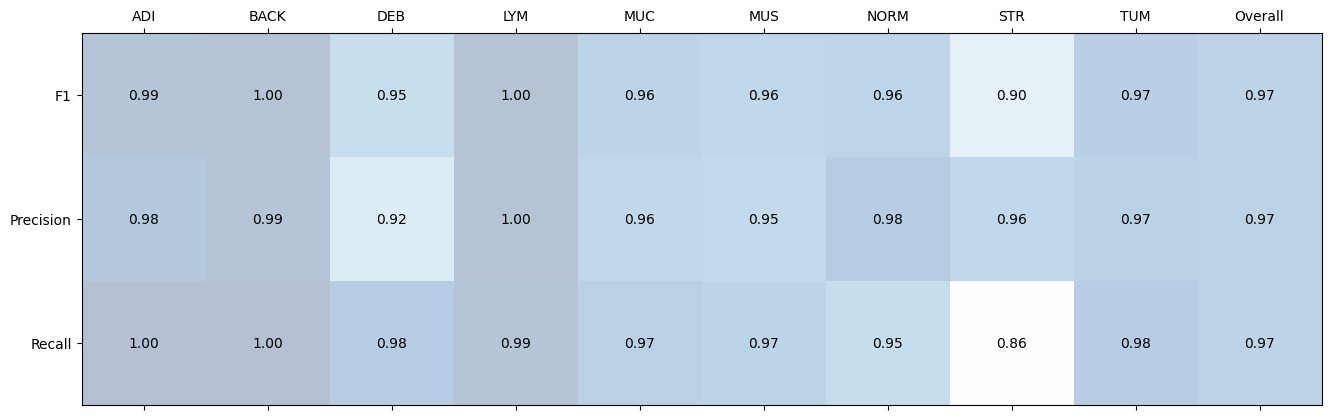

In [39]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )

In [40]:
save_path = "HoViT22_elastic_bsda.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to HoViT22_elastic_bsda.pth
